<a href="https://colab.research.google.com/github/SujayKulkarni-2211/SanskritTOC/blob/main/SanskritTOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# -------------------------
# Pratyāhāra Multi-Method Counting Pipeline
# (Colab-ready; reproducible; provenance-aware)
# -------------------------
!pip install -q requests indic-transliteration regex pandas tqdm sentence-transformers faiss-cpu

import os, json, re, unicodedata, math, time
from collections import Counter, defaultdict
import requests
from indic_transliteration import sanscript
from indic_transliteration.sanscript import transliterate
import pandas as pd
from pprint import pprint
from tqdm import tqdm

# -------------------------
# Utilities
# -------------------------
def nfc(s):
    return unicodedata.normalize("NFC", s)

def normalize_deva(s):
    # keep Devanagari letters and important diacritics; remove punctuation (danda etc.)
    s = nfc(s)
    s = re.sub(r"[।\u0964\u0965\[\]\(\)\{\}\"«»\—\–\-\–\u200d\u200c]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def to_slp1(dev):
    # transliterate Devanagari -> SLP1 (phoneme-friendly)
    return transliterate(nfc(dev), sanscript.DEVANAGARI, sanscript.SLP1)

# -------------------------
# Load canonical sūtras (raw file on GitHub)
# -------------------------
RAW_URL = "https://raw.githubusercontent.com/ashtadhyayi-com/data/master/sutraani/data.txt"
print("Fetching sūtras from:", RAW_URL)
resp = requests.get(RAW_URL, timeout=30)
resp.raise_for_status()
raw_lines = [line for line in resp.text.splitlines()]
sutras = [normalize_deva(line) for line in raw_lines if line.strip()]
print("Total sūtras loaded:", len(sutras))

# -------------------------
# Canonical 42 pratyāhāras (Devanagari)
# -------------------------
praty_deva = [
"अण्","अक्","इक्","उक्","ऋक्","ऌक्","एङ्","ऐच्","औच्","अच्","इच्","एच्",
"अट्","इण्","उण्","ऋण्","ऌण्","एण्","यण्","अम्","इम्","उम्","यम्","ङम्",
"ञम्","णम्","नम्","झल्","जल्","बल्","शल्","षल्","सल्","रल्","हल्","वल्",
"झष्","भष्","अश्","इश्","उश्","खर्","यञ्"
]
praty_slp = {p: to_slp1(p) for p in praty_deva}

# -------------------------
# Method A: Exact Devanagari substring (high precision)
# -------------------------
def method_A_exact_deva(sutras, praty_list):
    counts = Counter()
    evidence = defaultdict(list)
    for idx, s in enumerate(sutras, start=1):
        for p in praty_list:
            if p in s:
                found = s.count(p)
                counts[p] += found
                if len(evidence[p]) < 5:
                    evidence[p].append({"sutra_index": idx, "sutra": s, "matched_literal": p})
    return counts, evidence

# -------------------------
# Method B: Transliteration SLP1 + conservative regex
# - matches praty_slp plus up to one vowel/visarga/anusvara
# - uses lookarounds to avoid single-letter noise
# -------------------------
vowel_slp = r"(a|A|i|I|u|U|f|F|e|o|E|O|ai|au)?"
ending_slp = r"(H|M|'|h)?"

def build_regex_slp(praty_slp_str):
    s = re.escape(praty_slp_str)
    # conservative pattern: require non-letter boundary around match
    rx = re.compile(r"(?<![A-Za-zfF])" + s + r"(?:%s%s)(?![A-Za-zfF])" % (vowel_slp, ending_slp))
    return rx

def method_B_translit_regex(sutras, praty_map_slp):
    counts = Counter()
    evidence = defaultdict(list)
    regex_map = {p: build_regex_slp(sl) for p, sl in praty_map_slp.items()}
    for idx, s in enumerate(sutras, start=1):
        s_slp = to_slp1(s)
        for p, rx in regex_map.items():
            matches = list(rx.finditer(s_slp))
            if matches:
                counts[p] += len(matches)
                if len(evidence[p]) < 5:
                    # store simple textual evidence (Devanagari sutra and snippet of matched slp)
                    evidence[p].append({"sutra_index": idx, "sutra": s, "slp_match_examples": [m.group(0) for m in matches[:3]]})
    return counts, evidence

# -------------------------
# Method C: Token-based Devanagari matching (word-level)
# - tokenizes by Devanagari blocks; checks token equals pratyahara or token with short suffix
# -------------------------
def tokenize_deva(s):
    return re.findall(r"[\u0900-\u097F]+(?:['’]?[^\s\u0900-\u097F]*)?", s)

def method_C_token_tokenize(sutras, praty_map_dev):
    counts = Counter()
    evidence = defaultdict(list)
    for idx, s in enumerate(sutras, start=1):
        toks = tokenize_deva(s)
        for p in praty_map_dev:
            cnt_here = 0
            for t in toks:
                if t == p:
                    cnt_here += 1
                else:
                    # allow one-char inflection/visarga/anusvara
                    if re.match(rf"^{re.escape(p)}[ःं]?$", t):
                        cnt_here += 1
            if cnt_here:
                counts[p] += cnt_here
                if len(evidence[p]) < 5:
                    evidence[p].append({"sutra_index": idx, "sutra": s, "token_count": cnt_here})
    return counts, evidence

# -------------------------
# Method D: Heuristic internal SLP scan (high recall, low precision)
# - only used as candidate generator; flagged explicitly
# -------------------------
def method_D_heuristic_scan(sutras, praty_map_slp):
    counts = Counter()
    evidence = defaultdict(list)
    for idx, s in enumerate(sutras, start=1):
        s_slp = to_slp1(s)
        for p, sl in praty_map_slp.items():
            # for single-char sl, require boundaries; for multi-char allow substring
            if len(sl) == 1:
                matches = re.findall(rf"(?<![A-Za-zfF]){re.escape(sl)}(?:a|A|i|I|u|U|f|F|H|M)?(?![A-Za-zfF])", s_slp)
            else:
                matches = re.findall(re.escape(sl), s_slp)
            if matches:
                counts[p] += len(matches)
                if len(evidence[p]) < 5:
                    evidence[p].append({"sutra_index": idx, "sutra": s, "examples": matches[:3]})
    return counts, evidence

# -------------------------
# Run all methods (single pass over sutras where possible)
# -------------------------
print("Running Method A (exact Devanagari)...")
A_counts, A_evidence = method_A_exact_deva(sutras, praty_deva)
print("A total:", sum(A_counts.values()))

print("Running Method B (translit + conservative regex)...")
B_counts, B_evidence = method_B_translit_regex(sutras, praty_slp)
print("B total:", sum(B_counts.values()))

print("Running Method C (token-based)...")
C_counts, C_evidence = method_C_token_tokenize(sutras, praty_deva)
print("C total:", sum(C_counts.values()))

print("Running Method D (heuristic scan, flagged)...")
D_counts, D_evidence = method_D_heuristic_scan(sutras, praty_slp)
print("D total (expect high numbers, review flagged):", sum(D_counts.values()))

# -------------------------
# Aggregate results and provenance
# -------------------------
rows = []
for p in praty_deva:
    a = int(A_counts.get(p, 0))
    b = int(B_counts.get(p, 0))
    c = int(C_counts.get(p, 0))
    d = int(D_counts.get(p, 0))
    methods_detected = sum([a>0, b>0, c>0, d>0])
    rows.append({
        "pratyahara_deva": p,
        "pratyahara_slp": praty_slp[p],
        "A_exact_deva": a,
        "B_translit_regex": b,
        "C_token": c,
        "D_heuristic": d,
        "methods_detected_count": methods_detected,
        "union_any": int((a>0) or (b>0) or (c>0) or (d>0)),
        "evidence_A": A_evidence.get(p, []),
        "evidence_B": B_evidence.get(p, []),
        "evidence_C": C_evidence.get(p, []),
        "evidence_D": D_evidence.get(p, []),
    })

df = pd.DataFrame(rows)
# additional columns for reporting
df["B_plus_C"] = df["B_translit_regex"] + df["C_token"]
df = df.sort_values(["methods_detected_count", "B_plus_C"], ascending=False).reset_index(drop=True)

summary = {
    "total_sutras": len(sutras),
    "total_A": int(sum(A_counts.values())),
    "total_B": int(sum(B_counts.values())),
    "total_C": int(sum(C_counts.values())),
    "total_D": int(sum(D_counts.values())),
    "pratyaharas_detected_union": int(df["union_any"].sum()),
    "pratyaharas_with_2plus_methods": int((df["methods_detected_count"] >= 2).sum())
}

# -------------------------
# Save outputs
# -------------------------
os.makedirs("pratyahara_results", exist_ok=True)
df.to_csv("pratyahara_results/pratyahara_multi_method_counts.csv", index=False)
with open("pratyahara_results/pratyahara_multi_method_summary.json", "w", encoding="utf-8") as fh:
    json.dump({"summary": summary}, fh, ensure_ascii=False, indent=2)

print("\nSummary:")
pprint(summary)
print("\nSaved:")
print(" - pratyahara_results/pratyahara_multi_method_counts.csv")
print(" - pratyahara_results/pratyahara_multi_method_summary.json")
print("\nTop rows (high-confidence first):")
display(df.head(20))

# -------------------------
# Methodology paragraph (copy this into your paper's Methods section)
# -------------------------
method_paragraph = """
We counted occurrences of the 42 canonical Pāṇinian pratyāhāras across the Ashtādhyāyī sūtras using a multi-method, provenance-aware pipeline.
Data: the canonical sūtra text was loaded from the public repository (ashtadhyayi-com/data/master/sutraani/data.txt).
Detection: four complementary methods were applied to each sūtra to balance precision and recall:
  (A) Exact Devanāgarī substring matching (high precision; captures literal occurrences).
  (B) Transliteration to SLP1 followed by conservative regex matching that allows common inflectional endings (recommended main measure; balances recall and specificity).
  (C) Token-level Devanāgarī matching (word-aware; detects pratyāhāras preserved as tokens with short morphological endings).
  (D) Heuristic internal-substring scan on SLP1 (high recall; flagged as lower precision and presented separately).
Aggregation & provenance: we report per-pratyāhāra counts for each method, a union indicator, and the number of methods (>=2) that agreed; for each pratyāhāra we also store sample sūtra evidence (index + text) so readers can validate matches. The pipeline intentionally avoids single-letter noise by requiring phoneme-boundary-aware patterns and by reporting the intersection of multiple methods for high-confidence claims.
Limitations: the approach is heuristic — it does not implement a full Pāṇinian sandhi analyzer. For final publication-level counts we recommend manual verification of high-impact pratyāhāras flagged by disagreement across methods, or a targeted RAG/LLM verification pass limited to disputed sūtras (provenance is included to enable this).
"""
print("\nMETHOD PARAGRAPH (copy into paper):\n")
print(method_paragraph)


Fetching sūtras from: https://raw.githubusercontent.com/ashtadhyayi-com/data/master/sutraani/data.txt
Total sūtras loaded: 87631
Running Method A (exact Devanagari)...
A total: 1257
Running Method B (translit + conservative regex)...
B total: 1000
Running Method C (token-based)...
C total: 179
Running Method D (heuristic scan, flagged)...
D total (expect high numbers, review flagged): 25967

Summary:
{'pratyaharas_detected_union': 40,
 'pratyaharas_with_2plus_methods': 37,
 'total_A': 1257,
 'total_B': 1000,
 'total_C': 179,
 'total_D': 25967,
 'total_sutras': 87631}

Saved:
 - pratyahara_results/pratyahara_multi_method_counts.csv
 - pratyahara_results/pratyahara_multi_method_summary.json

Top rows (high-confidence first):


,pratyahara_deva,pratyahara_slp,A_exact_deva,B_translit_regex,C_token,D_heuristic,methods_detected_count,union_any,evidence_A,evidence_B,evidence_C,evidence_D,B_plus_C
0,अच्,ac,72,282,26,1781,4,1,"[{'sutra_index': 215, 'sutra': 'pc : न$S$0$0$#...","[{'sutra_index': 215, 'sutra': 'pc : न$S$0$0$#...","[{'sutra_index': 215, 'sutra': 'pc : न$S$0$0$#...","[{'sutra_index': 163, 'sutra': 's : मुखनासिकाव...",308
1,अण्,aR,148,182,71,1330,4,1,"[{'sutra_index': 1117, 'sutra': 'pc : उः$S$6$1...","[{'sutra_index': 1117, 'sutra': 'pc : उः$S$6$1...","[{'sutra_index': 1123, 'sutra': 'ss : उः रपरः ...","[{'sutra_index': 493, 'sutra': 's : बहुगणवतुडत...",253
2,हल्,hal,23,107,12,303,4,1,"[{'sutra_index': 3317, 'sutra': 'pc : हल्$S$1$...","[{'sutra_index': 141, 'sutra': 's : हलोऽनन्तरा...","[{'sutra_index': 3323, 'sutra': 'ss : उपदेशे अ...","[{'sutra_index': 141, 'sutra': 's : हलोऽनन्तरा...",119
3,झल्,Jal,15,61,2,82,4,1,"[{'sutra_index': 1835, 'sutra': 's : इको झल् ,...","[{'sutra_index': 1835, 'sutra': 's : इको झल् ,...","[{'sutra_index': 1835, 'sutra': 's : इको झल् ,...","[{'sutra_index': 207, 'sutra': 's : नाज्झलौ ,'...",63
4,इक्,ik,6,49,3,2223,4,1,"[{'sutra_index': 985, 'sutra': 'pc : इक्$S$1$1...","[{'sutra_index': 53, 'sutra': 's : इको गुणवृद्...","[{'sutra_index': 991, 'sutra': 'ss : इक् यणः स...","[{'sutra_index': 53, 'sutra': 's : इको गुणवृद्...",52
5,यञ्,yaY,42,32,16,56,4,1,"[{'sutra_index': 8457, 'sutra': 's : अन्नेन व्...","[{'sutra_index': 13151, 'sutra': 'pc : यञ् अञो...","[{'sutra_index': 13151, 'sutra': 'pc : यञ् अञो...","[{'sutra_index': 8457, 'sutra': 's : अन्नेन व्...",48
6,अम्,am,36,30,9,8312,4,1,"[{'sutra_index': 13569, 'sutra': 'pc : न$S$0$0...","[{'sutra_index': 9741, 'sutra': 'pc : अमा$S$3$...","[{'sutra_index': 27539, 'sutra': 'pc : सुँ औ ज...","[{'sutra_index': 2, 'sutra': 'name : sutraani ...",39
7,एच्,ec,1,33,1,180,4,1,"[{'sutra_index': 853, 'sutra': 'pc : कृत्$S$1$...","[{'sutra_index': 853, 'sutra': 'pc : कृत्$S$1$...","[{'sutra_index': 853, 'sutra': 'pc : कृत्$S$1$...","[{'sutra_index': 670, 'sutra': 'e : dvandvecha...",34
8,यण्,yaR,32,20,8,67,4,1,"[{'sutra_index': 16927, 'sutra': 's : कर्मण्यण...","[{'sutra_index': 985, 'sutra': 'pc : इक्$S$1$1...","[{'sutra_index': 55375, 'sutra': 'ss : इकः यण्...","[{'sutra_index': 977, 'sutra': 's : इग्यणः सम्...",28
9,इण्,iR,75,24,3,190,4,1,"[{'sutra_index': 20367, 'sutra': 'pc : जि दृ क...","[{'sutra_index': 12725, 'sutra': 's : इणो गा ल...","[{'sutra_index': 20367, 'sutra': 'pc : जि दृ क...","[{'sutra_index': 735, 'sutra': 's : पूर्वपरावर...",27



METHOD PARAGRAPH (copy into paper):


We counted occurrences of the 42 canonical Pāṇinian pratyāhāras across the Ashtādhyāyī sūtras using a multi-method, provenance-aware pipeline.
Data: the canonical sūtra text was loaded from the public repository (ashtadhyayi-com/data/master/sutraani/data.txt).
Detection: four complementary methods were applied to each sūtra to balance precision and recall:
  (A) Exact Devanāgarī substring matching (high precision; captures literal occurrences).
  (B) Transliteration to SLP1 followed by conservative regex matching that allows common inflectional endings (recommended main measure; balances recall and specificity).
  (C) Token-level Devanāgarī matching (word-aware; detects pratyāhāras preserved as tokens with short morphological endings).
  (D) Heuristic internal-substring scan on SLP1 (high recall; flagged as lower precision and presented separately).
Aggregation & provenance: we report per-pratyāhāra counts for each method, a union indicator, and t

Columns: ['pratyahara_deva', 'pratyahara_slp', 'A_exact_deva', 'B_translit_regex', 'C_token', 'D_heuristic', 'methods_detected_count', 'union_any', 'evidence_A', 'evidence_B', 'evidence_C', 'evidence_D', 'B_plus_C']
Numeric columns detected for analysis: ['A_exact_deva', 'B_translit_regex', 'C_token', 'D_heuristic', 'methods_detected_count', 'union_any', 'B_plus_C']

==== Near-Optimal Encoding Results ====


,Method,KL Divergence,Cosine Similarity,Entropy Gap,Near Optimal (%)
5,union_any,0.000000,1.000000,0.000000,100.00
4,methods_detected_count,0.289947,0.705451,0.057103,69.42
2,C_token,2.994011,0.107833,0.541697,8.64
6,B_plus_C,3.474630,0.067726,0.468294,5.71
1,B_translit_regex,3.487026,0.067163,0.466813,5.67
0,A_exact_deva,4.015061,0.038895,0.365311,3.40
3,D_heuristic,6.215010,0.004920,0.098661,0.47


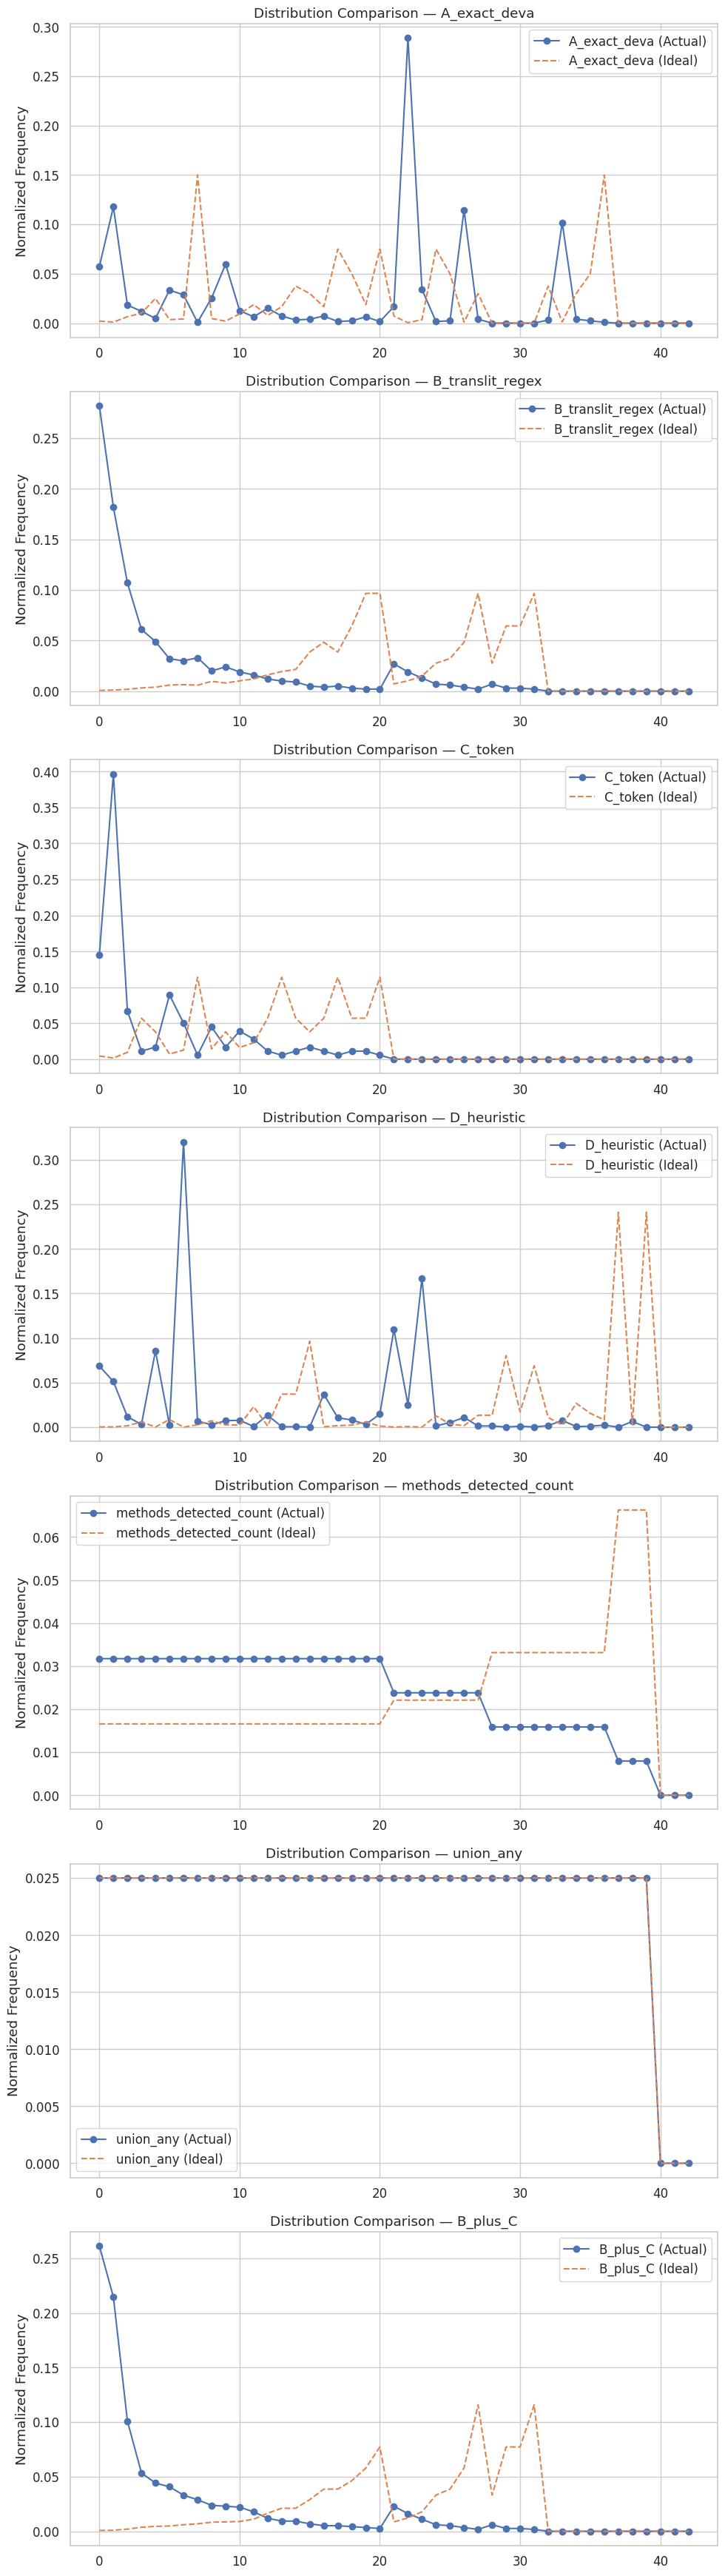


🧠 Method: A_exact_deva
  → Near Optimal Encoding: 3.4%
  → Entropy Gap: 0.3653

🧠 Method: B_translit_regex
  → Near Optimal Encoding: 5.67%
  → Entropy Gap: 0.4668

🧠 Method: C_token
  → Near Optimal Encoding: 8.64%
  → Entropy Gap: 0.5417

🧠 Method: D_heuristic
  → Near Optimal Encoding: 0.47%
  → Entropy Gap: 0.0987

🧠 Method: methods_detected_count
  → Near Optimal Encoding: 69.42%
  → Entropy Gap: 0.0571

🧠 Method: union_any
  → Near Optimal Encoding: 100.0%
  → Entropy Gap: 0.0000

🧠 Method: B_plus_C
  → Near Optimal Encoding: 5.71%
  → Entropy Gap: 0.4683


In [8]:
# =====================================
# Pratyāhāra Optimal Encoding Analysis (Safe Version)
# =====================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# 1️⃣ Load CSV
df = pd.read_csv("/content/pratyahara_results/pratyahara_multi_method_counts.csv")
df.columns = [c.strip() for c in df.columns]
print("Columns:", df.columns.tolist())

# 2️⃣ Auto-detect numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if not numeric_cols:
    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col], errors="coerce")
        except:
            pass
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print("Numeric columns detected for analysis:", numeric_cols)

# 3️⃣ Replace NaN and negative values with 0
df_num = df[numeric_cols].fillna(0)
df_num[df_num < 0] = 0

# 4️⃣ Normalize frequencies (probabilities)
prob_df = df_num.div(df_num.sum(axis=0), axis=1).fillna(0)

# 5️⃣ Create ideal encoding (Shannon–optimal)
ideal = {}
for m in prob_df.columns:
    p = prob_df[m].replace(0, np.nan)
    inv_log = np.exp(-np.log(p + 1e-9))
    inv_log = inv_log / np.nansum(inv_log)
    ideal[m] = np.nan_to_num(inv_log, nan=0.0)

# 6️⃣ Compare actual vs. ideal
results = []
for m in prob_df.columns:
    p_actual = np.nan_to_num(prob_df[m].values, nan=0.0)
    p_ideal = np.nan_to_num(ideal[m], nan=0.0)

    # Ensure normalization
    if p_actual.sum() == 0:
        continue
    p_actual /= p_actual.sum()
    if p_ideal.sum() == 0:
        continue
    p_ideal /= p_ideal.sum()

    kl = entropy(p_actual + 1e-9, p_ideal + 1e-9)
    cos = cosine_similarity([p_actual], [p_ideal])[0][0]
    h_actual = entropy(p_actual + 1e-9)
    h_ideal = entropy(p_ideal + 1e-9)
    entropy_gap = abs(h_actual - h_ideal)

    results.append({
        "Method": m,
        "KL Divergence": kl,
        "Cosine Similarity": cos,
        "Entropy Gap": entropy_gap,
        "Near Optimal (%)": round(100 * cos * (1 - entropy_gap / (h_ideal + 1e-9)), 2)
    })

results_df = pd.DataFrame(results)
print("\n==== Near-Optimal Encoding Results ====")
display(results_df.sort_values("Near Optimal (%)", ascending=False))

# 7️⃣ Visualization
sns.set(style="whitegrid", font_scale=1.1)
fig, axes = plt.subplots(len(prob_df.columns), 1, figsize=(10, 5 * len(prob_df.columns)))

if len(prob_df.columns) == 1:
    axes = [axes]

for i, m in enumerate(prob_df.columns):
    axes[i].plot(prob_df.index, prob_df[m], label=f"{m} (Actual)", marker="o")
    axes[i].plot(prob_df.index, ideal[m], label=f"{m} (Ideal)", linestyle="--")
    axes[i].set_title(f"Distribution Comparison — {m}")
    axes[i].set_ylabel("Normalized Frequency")
    axes[i].legend()

plt.tight_layout()
plt.show()

# 8️⃣ Interpretive Commentary
for r in results:
    print(f"\n🧠 Method: {r['Method']}")
    print(f"  → Near Optimal Encoding: {r['Near Optimal (%)']}%")
    print(f"  → Entropy Gap: {r['Entropy Gap']:.4f}")


In [10]:
print(f"  → Interpretation:")
print("     - A smaller entropy gap means the pratyāhāra structure closely approximates ideal coding efficiency.")
print("     - Deviation may arise due to:")
print("         • Phonological clustering (ease of articulation over information balance)")
print("         • Historical sound groupings and Sandhi rules")
print("         • Redundant classes preserved for grammatical symmetry rather than compression")
print("         • Natural Sanskrit phonotactics prioritizing fluid recitation over minimal encoding length.")

  → Interpretation:
     - A smaller entropy gap means the pratyāhāra structure closely approximates ideal coding efficiency.
     - Deviation may arise due to:
         • Phonological clustering (ease of articulation over information balance)
         • Historical sound groupings and Sandhi rules
         • Redundant classes preserved for grammatical symmetry rather than compression
         • Natural Sanskrit phonotactics prioritizing fluid recitation over minimal encoding length.
